In [4]:
import json
from utils.gho_filter import filter_gho_users

with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

gho_users = set(filter_gho_users(data))

In [5]:
with open('results_v2.json', 'r') as fp:
    res = json.load(fp)
v2_data = []
for entry in res:
    v2_data += entry['data']['users']

In [6]:
v2_users = set([entry['id'] for entry in v2_data])

In [7]:
tokens_of_interest = ["USDC", "USDT", "WETH", "DAI", "WBTC", "GHO", "LUSD", "PYUSD", "crvUSD"]

In [8]:
new_borrows = []
history = 'borrowHistory'
for entry in data:
    user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
    if len(user_ordered_tx) == 0:
        continue
    if entry['id'] in v2_users:
        continue
    elif (user_ordered_tx[0]['timestamp'] > 1720965600) or (not (user_ordered_tx[0]['timestamp'] > 1689343200)):
        continue
    elif user_ordered_tx[0]['reserve']['symbol'] not in tokens_of_interest:
        continue
    else:
        new_borrows.append(entry)
len(new_borrows)

11116

In [9]:
user_actions = {}
for entry in new_borrows:
    actions = entry['borrowHistory'] + entry['supplyHistory']
    user_ordered_tx = sorted(actions, key=lambda x: x['timestamp'])
    # we remove the supply txs prior to any first borrow
    first_reached = False
    filtered_actions = []
    for a in user_ordered_tx:
        if (first_reached == False) and a['action'] != 'Borrow':
            continue
        else:
            first_reached = True
            filtered_actions.append(a)
    user_actions[entry['id']] = filtered_actions

In [10]:
user_actions['0x00001e52eae2f7305b198b9e4f2c64fb1102de11']

KeyError: '0x00001e52eae2f7305b198b9e4f2c64fb1102de11'

In [11]:
def categorize_actions(num_actions):
    return min(num_actions, 7)

In [12]:
token_survival_rates = {}

In [18]:
from collections import defaultdict
import matplotlib.pyplot as plt

def compute_survival_rates(user_actions):
    token_survival = defaultdict(lambda: [0] * 10)
    token_users = defaultdict(int)

    for user, actions in user_actions.items():
        if not actions:
            continue
        
        first_token = actions[0]['reserve']['symbol']
        token_users[first_token] += 1
        
        for i in range(min(len(actions), 10)):
            token_survival[first_token][min(i, 9)] += 1

    survival_rates = {}
    for token, counts in token_survival.items():
        total_users = token_users[token]
        rates = [count / total_users for count in counts if (count != total_users)]
        survival_rates[token] = rates

    return survival_rates

survival_rates = compute_survival_rates(user_actions)

In [19]:
survival_rates

{'USDT': [0.7591693635382956,
  0.6294498381877023,
  0.5218446601941747,
  0.4452535059331176,
  0.38727076591154264,
  0.33360302049622437,
  0.29395900755124055,
  0.261596548004315,
  0.23516720604099245],
 'USDC': [0.7562412342215988,
  0.6350631136044881,
  0.5273492286115007,
  0.44431977559607294,
  0.37952314165497897,
  0.33492286115007014,
  0.297054698457223,
  0.26956521739130435,
  0.24516129032258063],
 'DAI': [0.7903780068728522,
  0.6563573883161512,
  0.5309278350515464,
  0.44673539518900346,
  0.39347079037800686,
  0.34536082474226804,
  0.31099656357388317,
  0.2766323024054983,
  0.24570446735395188],
 'crvUSD': [0.8205128205128205,
  0.5384615384615384,
  0.4358974358974359,
  0.41025641025641024,
  0.3076923076923077,
  0.28205128205128205,
  0.20512820512820512,
  0.1282051282051282,
  0.1282051282051282],
 'GHO': [0.6188118811881188,
  0.504950495049505,
  0.41707920792079206,
  0.36386138613861385,
  0.29826732673267325,
  0.2660891089108911,
  0.24504950495

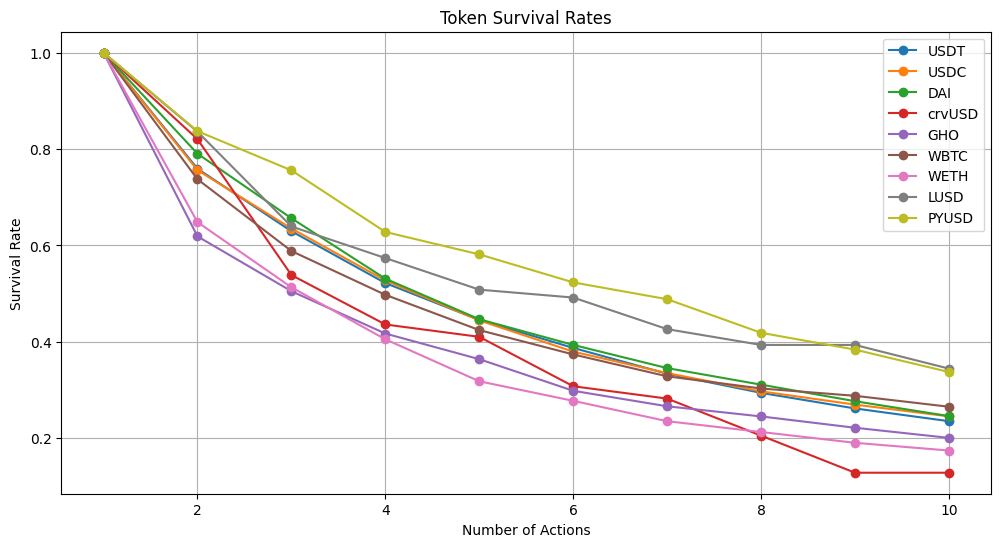

In [15]:
plt.figure(figsize=(12, 6))
for token, rates in survival_rates.items():
    plt.plot(range(1, 11), rates, marker='o', label=token)

plt.xlabel('Number of Actions')
plt.ylabel('Survival Rate')
plt.title('Token Survival Rates')
plt.legend()
plt.grid(True)